This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [1]:
import argparse
import pathlib
import shutil
import subprocess  # subprocess handling
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch
import tqdm
from cellpose import core, models
from cellpose.io import imread
from PIL import Image
from skimage import io

use_GPU = torch.cuda.is_available()

# set import path
sys.path.append(str(pathlib.Path("../../utils/").resolve()))

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

True


In [6]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--patient",
        type=str,
        help="Patient ID to use for the segmentation",
    )

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--window_size", type=int, help="Size of the window to use for the segmentation"
    )
    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )

    args = parser.parse_args()
    window_size = args.window_size
    clip_limit = args.clip_limit
    well_fov = args.well_fov
    patient = args.patient

else:
    well_fov = "C3-2"
    window_size = 4
    clip_limit = 0.05
    patient = "NF0016"


input_dir = pathlib.Path(f"../../data/{patient}/zstack_images/{well_fov}").resolve(
    strict=True
)

mask_path = pathlib.Path(
    f"../../data/{patient}/processed_data/{input_dir.stem}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

## Set up images, paths and functions

In [7]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [8]:
# find the cytoplasmic channels in the image set
for f in files:
    if "405" in f:
        nuclei = io.imread(f)
    elif "488" in f:
        cyto1 = io.imread(f)
    elif "555" in f:
        cyto2 = io.imread(f)
    elif "640" in f:
        cyto3 = io.imread(f)
    elif "TRANS" in f:
        brightfield = io.imread(f)
    else:
        print(f"Unknown channel: {f}")

cyto = np.max(
    [
        # cyto1,
        cyto2,
        cyto3,
    ],
    axis=0,
)
# pick which channels to use for cellpose
# cyto = skimage.exposure.equalize_adapthist(cyto, clip_limit=clip_limit)


original_cyto_image = cyto.copy()

original_cyto_z_count = cyto.shape[0]

In [5]:
# make a 2.5 D max projection image stack with a sliding window of 3 slices
image_stack_2_5D = np.empty((0, cyto.shape[1], cyto.shape[2]), dtype=cyto.dtype)
for image_index in range(cyto.shape[0]):
    image_stack_window = cyto[image_index : image_index + window_size]
    if not image_stack_window.shape[0] == window_size:
        break
    # guassian blur the image stack to smooth the global intensity
    image_stack_window = skimage.filters.gaussian(image_stack_window, sigma=1)
    # max project the image stack for the sliding window
    image_stack_2_5D = np.append(
        image_stack_2_5D, np.max(image_stack_window, axis=0)[np.newaxis, :, :], axis=0
    )

image_stack_2_5D = np.array(image_stack_2_5D)
cyto = np.array(image_stack_2_5D)
print("2.5D cyto image stack shape:", cyto.shape)

2.5D cyto image stack shape: (4, 1537, 1540)


Optimizing the butterworth filter for 25 pairs


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


Optimization complete - plotting the results


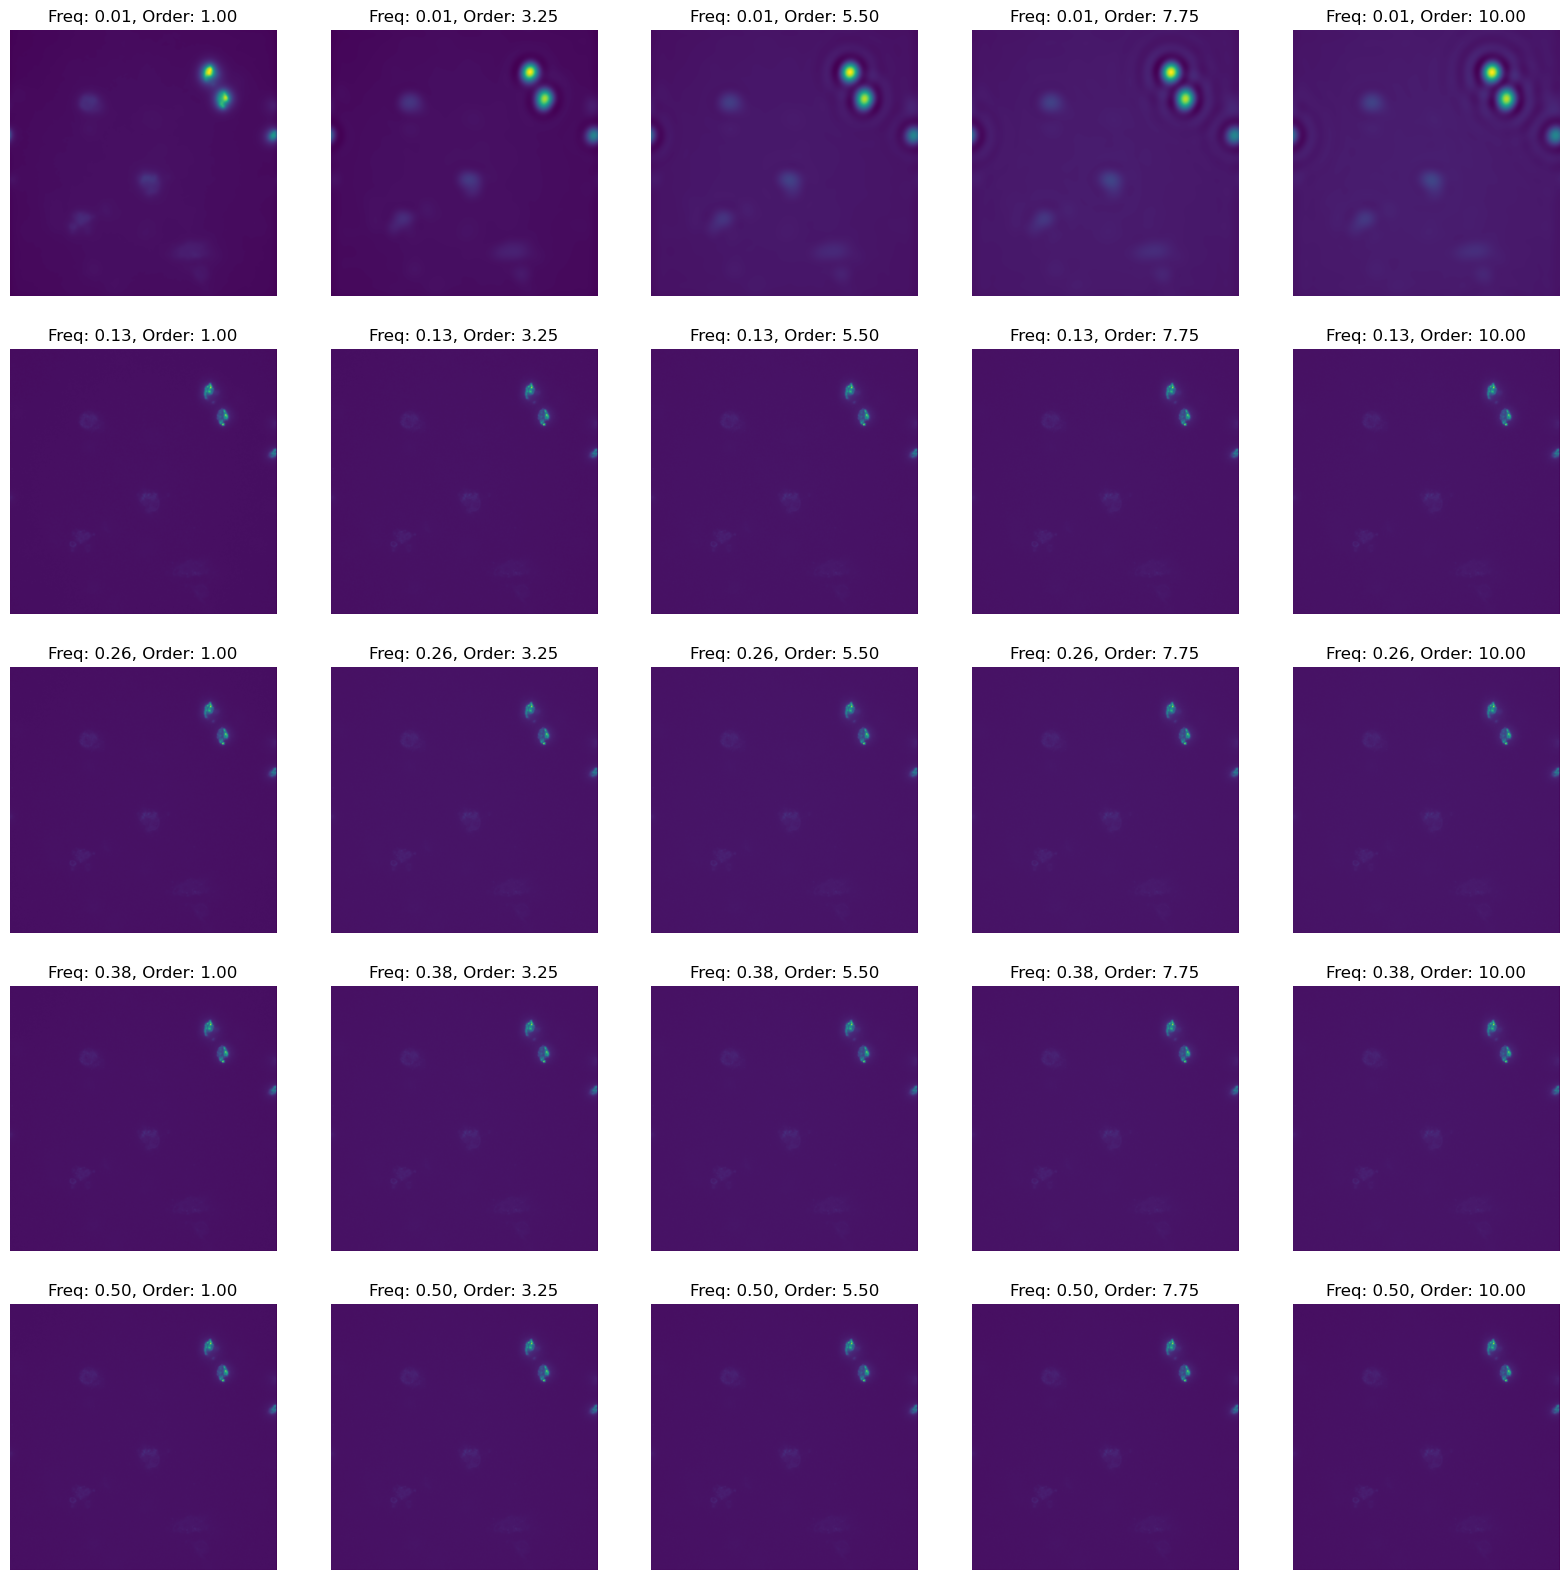

In [6]:
butterworth_optimization = True
if butterworth_optimization:
    # get the median most image from the cyto image stack
    # this is the image that will be used for the butterworth filter optimization
    # get the median image from the cyto image stack
    middle_index = int(cyto.shape[0] / 2)
    img_to_optimize = cyto[middle_index]
    optimization_steps = 5
    # optimize the butterworth filter for the cyto image
    search_space_cutoff_freq = np.linspace(0.01, 0.5, optimization_steps)
    search_space_order = np.linspace(1, 10, optimization_steps)
    # create a list of optimzation parameter pairs
    optimization_parameter_pairs = []
    for cutoff_freq_option in search_space_cutoff_freq:
        for order_option in search_space_order:
            optimization_parameter_pairs.append((cutoff_freq_option, order_option))
    print(
        f"Optimizing the butterworth filter for {len(optimization_parameter_pairs)} pairs"
    )
    optimized_images = []
    # loop through the optimization pairs to find the best pararmeters
    for cutoff_freq_option, order_option in tqdm.tqdm(optimization_parameter_pairs):
        optimized_images.append(
            skimage.filters.butterworth(
                img_to_optimize,
                cutoff_frequency_ratio=cutoff_freq_option,
                high_pass=False,
                order=order_option,
                squared_butterworth=True,
            )
        )
    if in_notebook:
        print("Optimization complete - plotting the results")
        # visualize the optimized images in a grid
        fig, ax = plt.subplots(optimization_steps, optimization_steps, figsize=(20, 20))
        for i in range(optimization_steps):
            for j in range(optimization_steps):
                ax[i, j].imshow(optimized_images[i * optimization_steps + j])
                ax[i, j].axis("off")
                # add the cutoff frequency and order to the plot
                ax[i, j].set_title(
                    f"Freq: {search_space_cutoff_freq[i]:.2f}, Order: {search_space_order[j]:.2f}"
                )
        plt.show()

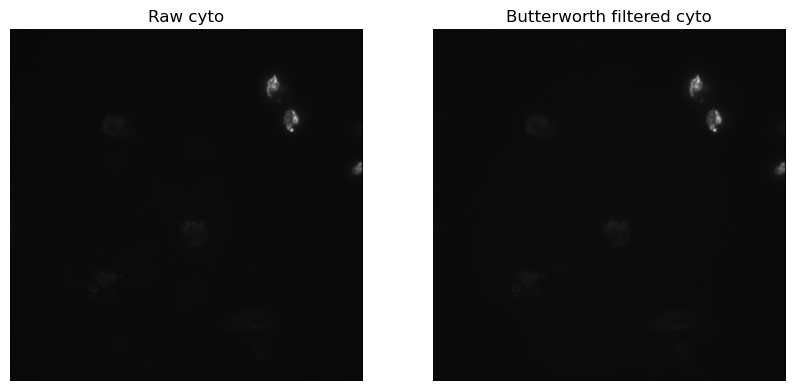

In [7]:
# Use butterworth FFT filter to remove high frequency noise :)
imgs = skimage.filters.butterworth(
    cyto,
    cutoff_frequency_ratio=0.5,
    high_pass=False,
    order=1,
    squared_butterworth=True,
)
if in_notebook:
    # plot the nuclei and the cyto channels
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(cyto[middle_index, :, :], cmap="gray")
    plt.title("Raw cyto")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(imgs[middle_index, :, :], cmap="gray")
    plt.title("Butterworth filtered cyto")
    plt.axis("off")
    plt.show()

In [8]:
use_GPU = torch.cuda.is_available()
# Load the model
model_name = "cyto3"
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

output_dict = {
    "slice": [],
    "labels": [],
    "details": [],
}
for slice in tqdm.tqdm(range(imgs.shape[0])):
    # Perform segmentation of whole organoids
    labels, details, _ = model.eval(
        imgs[slice, :, :],
        channels=[1, 0],
        z_axis=0,
        diameter=750,
    )
    output_dict["slice"].append(slice)
    output_dict["labels"].append(labels)
    output_dict["details"].append(details)

100%|██████████| 4/4 [00:17<00:00,  4.46s/it]


In [9]:
# reverse sliding window max projection
full_mask_z_stack = []
reconstruction_dict = {index: [] for index in range(original_cyto_z_count)}
print(f"Decoupling the sliding window max projection of {window_size} slices")

# decouple the sliding window max projection based on window size
# each slice in a stack
for z_stack_mask_index in range(len(output_dict["labels"])):
    # temoporary list to hold the decoupled z stack
    z_stack_decouple = []
    # decouple
    [
        z_stack_decouple.append(output_dict["labels"][z_stack_mask_index])
        for _ in range(window_size)
    ]
    # dull out the decouple slice to the correct z index
    for z_window_index, z_stack_mask in enumerate(z_stack_decouple):
        if not (z_stack_mask_index + z_window_index) >= original_cyto_z_count:
            reconstruction_dict[z_stack_mask_index + z_window_index].append(
                z_stack_mask
            )
# save the reconstruction_dict to a file for downstream decoupling
np.save(mask_path / "organoid_reconstruction_dict.npy", reconstruction_dict)

Decoupling the sliding window max projection of 4 slices


<Figure size 1000x500 with 0 Axes>

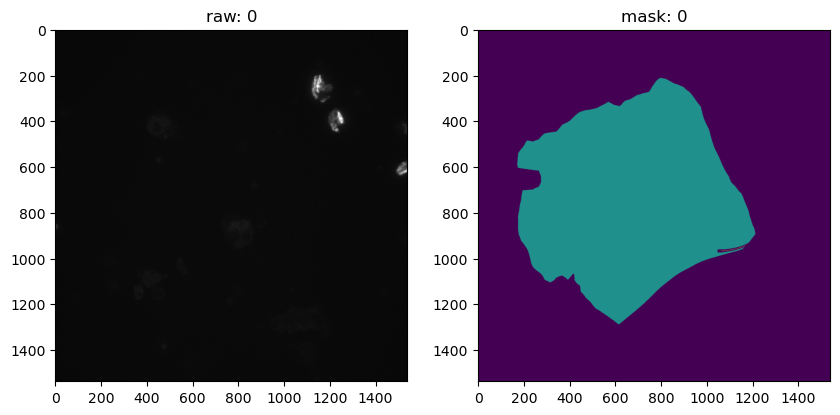

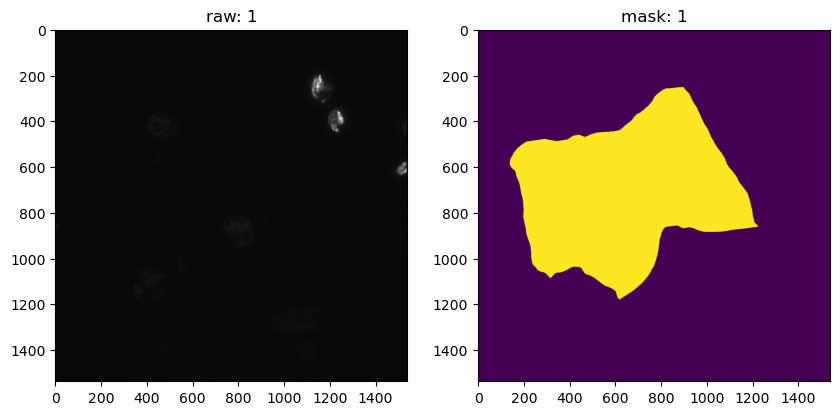

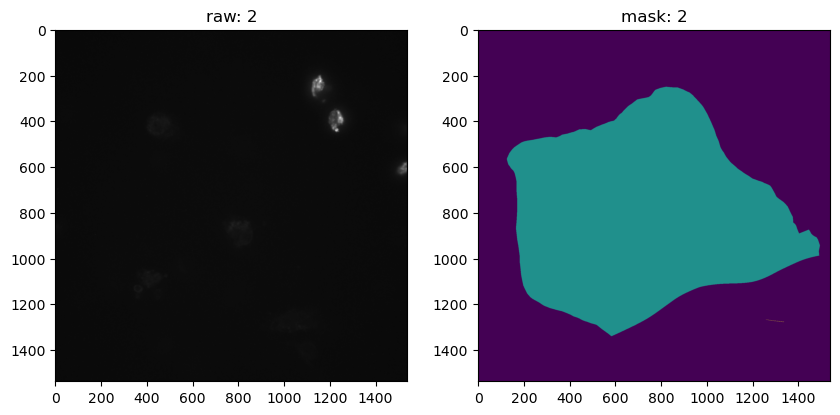

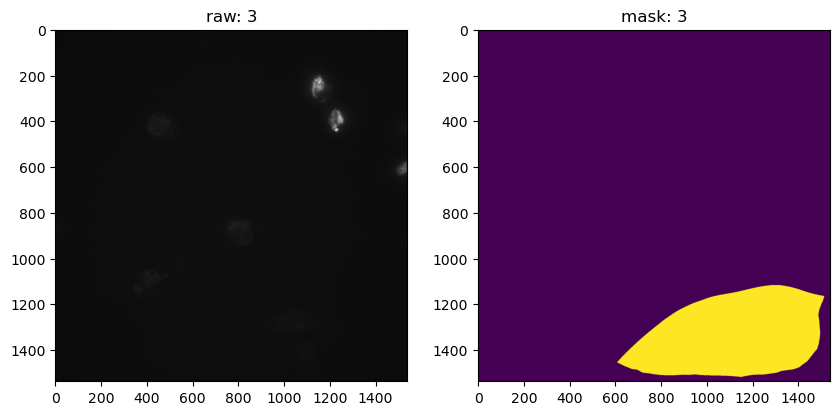

In [10]:
if in_notebook:
    # masks, flows, styles, diams
    plot = plt.figure(figsize=(10, 5))
    for z in range(len(output_dict["labels"])):
        plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(imgs[z], cmap="gray")
        plt.title(f"raw: {z}")
        plt.subplot(122)
        plt.imshow(output_dict["labels"][z])
        plt.title(f"mask: {z}")
        plt.show()